# Gestión de Datos (Data Management)

¡Bienvenido al laboratorio de Gestión de Datos!

En laboratorios anteriores, te enfocaste en construir y entrenar modelos con datos bien estructurados. Sin embargo, en el mundo real, los datos rara vez son perfectos. Incluso la arquitectura de modelo más potente puede fallar si se alimenta de un flujo de datos desordenado, ineficiente o poco fiable. Aquí es donde un **pipeline de datos** robusto se vuelve esencial.

Este laboratorio cambia tu enfoque del modelo hacia los datos mismos, abordando los desafíos comunes de los conjuntos de datos del mundo real. Trabajarás con el dataset **[Oxford 102 Flowers](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)**, una colección de imágenes y etiquetas almacenadas en archivos separados, con formatos inconsistentes y posiblemente incluso algunas muestras corruptas. Para superar estos obstáculos, utilizarás las herramientas principales de gestión de datos de PyTorch: las clases **`Dataset`** y **`DataLoader`**.

En este laboratorio, vas a:

* Explorar un conjunto de datos del mundo real con archivos desorganizados y etiquetas separadas.
* Construir un **`Dataset`** de PyTorch personalizado para cargar y preprocesar imágenes y etiquetas sobre la marcha (on-the-fly).
* Aplicar **transformaciones** y **aumento de datos (data augmentation)** para preparar tus datos y mejorar la robustez del modelo.
* Utilizar el **`DataLoader`** para crear y mezclar (shuffle) lotes de forma eficiente para el entrenamiento.
* Dividir tus datos en conjuntos de entrenamiento, validación y prueba.
* Implementar técnicas de manejo de errores para gestionar problemas de datos y monitorear el rendimiento de tu pipeline.

## Imports

In [1]:
import os
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm

import helper_utils

## Acceso a Datos (Data Access)

Cada proyecto de deep learning comienza con datos, pero no todos los datos están listos para ser usados. 
A veces ya están bien organizados, pero a menudo están dispersos o almacenados en formatos que no son directamente compatibles con el entrenamiento del modelo.
En esta sección, aprenderás cómo gestionar el acceso a los datos y seguir las mejores prácticas para trabajar con conjuntos de datos desorganizados o inconsistentes.

### Exploración del Conjunto de Datos (Dataset Exploration)

El primer paso cuando se trabaja con un nuevo conjunto de datos es acceder y explorar su estructura.
Esto te ayuda a comprender cómo están organizados los datos y, por lo tanto, cómo cargarlos y utilizarlos de manera efectiva.

* Definirás una función `download_dataset` que descarga el conjunto de datos desde una URL determinada y lo extrae en un directorio especificado.
* En este caso, el conjunto de datos consta de dos archivos: un archivo `.tgz` con imágenes y un archivo `.mat` que contiene las etiquetas.

Ambos archivos se descargarán utilizando la librería `requests` y luego se extraerán utilizando la librería `tarfile`.

In [2]:
def download_dataset():
    """
    Descarga y extrae un conjunto de datos desde URLs remotas si no está presente localmente.

    Esta función primero verifica la existencia de los archivos del dataset en un directorio
    específico. Si no se encuentran los archivos, procede a descargarlos desde URLs
    predefinidas, mostrando barras de progreso, y luego extrae el contenido.
    """
    # Definir el directorio para almacenar el conjunto de datos.
    data_dir = "flower_data"
    
    # Definir rutas para archivos y carpetas clave.
    image_folder_path = os.path.join(data_dir, "jpg")
    labels_file_path = os.path.join(data_dir, "imagelabels.mat")
    tgz_path = os.path.join(data_dir, "102flowers.tgz")

    # Verificar si la carpeta de datos principal y un archivo de etiquetas clave ya existen.
    if os.path.exists(image_folder_path) and os.path.exists(labels_file_path):
        # Informar al usuario que el dataset ya está disponible localmente.
        print(f"Dataset already exists. Loading locally from '{data_dir}'.")
        # Salir de la función ya que no es necesaria la descarga.
        return

    # Informar al usuario que el dataset no se encontró y que comenzará la descarga.
    print("Dataset not found locally. Downloading...")

    # Definir las URLs para el archivo de imágenes y el archivo de etiquetas.
    image_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
    labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"

    # Crear el directorio de destino para el dataset, si aún no existe.
    os.makedirs(data_dir, exist_ok=True)

    # Anunciar el inicio del proceso de descarga de imágenes.
    print("Downloading images...")
    # Enviar una solicitud HTTP GET a la URL de la imagen, habilitando el streaming para archivos grandes.
    response = requests.get(image_url, stream=True)
    # Obtener el tamaño total del archivo de los encabezados de respuesta para la barra de progreso.
    total_size = int(response.headers.get("content-length", 0))

    # Abrir un archivo local en modo de escritura binaria para guardar el archivo descargado.
    with open(tgz_path, "wb") as file:
        # Iterar sobre el contenido de la respuesta en trozos (chunks) con una barra de progreso.
        for data in tqdm(
            # Definir el tamaño del trozo para iterar sobre el contenido.
            response.iter_content(chunk_size=1024),
            # Establecer el total para la barra de progreso basado en el tamaño del archivo en kilobytes.
            total=total_size // 1024,
        ):
            # Escribir cada trozo de datos en el archivo.
            file.write(data)

    # Anunciar el inicio del proceso de extracción de archivos.
    print("Extracting files...")
    # Abrir el archivo tar.gz descargado en modo lectura.
    with tarfile.open(tgz_path, "r:gz") as tar:
        # Extraer todo el contenido del archivo en el directorio de destino.
        tar.extractall(data_dir)

    # Anunciar el inicio del proceso de descarga de etiquetas.
    print("Downloading labels...")
    # Enviar una solicitud HTTP GET a la URL de las etiquetas.
    response = requests.get(labels_url)
    # Abrir un archivo local en modo de escritura binaria para guardar las etiquetas.
    with open(labels_file_path, "wb") as file:
        # Escribir todo el contenido de la respuesta en el archivo.
        file.write(response.content)

    # Informar al usuario que la descarga y extracción se han completado.
    print(f"Dataset downloaded and extracted to '{data_dir}'.")

    # Crear labels_description.txt
    labels_description = [
        'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily',
        'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea',
        'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower',
        'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
        'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation',
        'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower',
        'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia',
        'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia',
        'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia',
        'pink-yellow dahlia?', 'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy',
        'osteospermum', 'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea', 'water lily',
        'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', 'frangipani',
        'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress',
        'canna lily', 'hippeastrum ', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia', 'mallow',
        'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper', 'blackberry lily'
    ]

    with open(os.path.join(data_dir, "labels_description.txt"), "w") as f:
        for idx, label in enumerate(labels_description, start=1):
            f.write(f"{label}\n")

In [3]:
# Call the function to download and prepare the dataset.
download_dataset()

Dataset not found locally. Downloading...


  0%|          | 0/336779 [00:00<?, ?it/s]

Extracting files...


/tmp/ipykernel_3023/2483149399.py:58: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_dir)


Dataset downloaded and extracted to 'flower_data'.


In [4]:
# Define the path to the root directory of the dataset.
path_dataset = './flower_data'

# Display the folder structure of the dataset directory up to a depth of one.
helper_utils.print_data_folder_structure(path_dataset, max_depth=1)

flower_data/
├── 102flowers.tgz
├── imagelabels.mat
├── jpg/
└── labels_description.txt


<br>

Puedes ver que el conjunto de datos consiste en:
- Una carpeta `jpg` que contiene imágenes en formato JPEG.
- Un archivo `imagelabels.mat` que almacena las etiquetas (formato MATLAB).
- Un archivo `labels_description.txt` que describe cada etiqueta.

Esto te da una idea clara de cómo está estructurado el conjunto de datos y con qué estarás trabajando.

### Creación de una Clase Dataset Personalizada

Después de haber descargado y explorado brevemente el conjunto de datos, el siguiente paso es crear una clase de dataset personalizada que organice el acceso a los datos. El objetivo es recuperar las imágenes y sus etiquetas correspondientes de manera consistente y eficiente para el entrenamiento del modelo.

Crearás una clase `FlowerDataset` que hereda de `torch.utils.data.Dataset`.
Una clase de dataset personalizada *debe* implementar los siguientes métodos:

> `__init__`: Inicializa el objeto del dataset.
> * Típicamente acepta la ruta de los datos y cualquier transformación (transforms) a aplicar.
> * Opcionalmente, carga metadatos o etiquetas asociadas con los datos.

> `__len__`: Devuelve el número de muestras en el dataset.

> `__getitem__`: Recupera una sola muestra dado un índice.
> * Carga la imagen y su etiqueta, aplica las transformaciones y las devuelve.

Además, definirás métodos auxiliares para que el código sea más limpio y organizado:

> `load_and_correct_labels`: Carga las etiquetas de las imágenes desde el archivo MATLAB .mat.
> * Utiliza `scipy.io.loadmat` para leer el archivo y extraer el arreglo de etiquetas.
> * Las etiquetas se ajustan restando 1, lo cual es necesario porque MATLAB utiliza indexación basada en 1, mientras que Python utiliza indexación basada en 0. 
>    * Esta corrección evita errores de desfase por uno (off-by-one errors) durante el entrenamiento y la evaluación.

> `retrieve_image`: Carga una imagen del disco dado su índice `idx`. 
> * Dado el `idx`, construye el nombre del archivo y la ruta, abre la imagen usando la librería Pillow, la convierte a formato RGB (para asegurar la consistencia) y devuelve el objeto de la imagen.

> `get_label_description`: Dada una etiqueta, devuelve una descripción legible para humanos desde el archivo de texto.

**Sobre la carga perezosa (Lazy Loading)**:
Las imágenes no se cargan todas a la vez cuando se crea el objeto del dataset.
En su lugar, se cargan sobre la marcha (on-the-fly) cuando se accede a ellas a través del método `__getitem__`.
Este enfoque es eficiente en cuanto al uso de memoria, especialmente cuando se trabaja con conjuntos de datos grandes, ya que evita cargar todas las imágenes en la memoria de una sola vez.

In [5]:
class FlowerDataset(Dataset):
    """
    Una clase de dataset personalizada para cargar datos de imágenes de flores.

    Esta clase está diseñada para trabajar con las abstracciones Dataset y DataLoader de PyTorch.
    Se encarga de cargar imágenes y sus etiquetas correspondientes desde una estructura
    de directorios específica.
    """
    def __init__(self, root_dir, transform=None):
        """
        Inicializa el objeto del dataset.

        Args:
            root_dir (str): El directorio raíz donde se almacena el conjunto de datos.
            transform (callable, opcional): Transformación opcional que se aplicará sobre una muestra.
        """
        # Almacena la ruta del directorio raíz.
        self.root_dir = root_dir
        # Almacena las transformaciones opcionales.
        self.transform = transform
        # Construye la ruta completa al directorio de imágenes.
        self.image_dir = os.path.join(self.root_dir, "jpg")
        # Carga y procesa las etiquetas desde el archivo correspondiente.
        self.labels = self.load_and_correct_labels()

    def __len__(self):
        """
        Devuelve el número total de muestras en el conjunto de datos.
        """
        # El número total de muestras es el número de etiquetas.
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Recupera una muestra del conjunto de datos en el índice especificado.

        Args:
            idx (int): El índice de la muestra a recuperar.

        Retorna:
            tuple: Una tupla que contiene la imagen y su etiqueta.
        """
        # Recupera la imagen para el índice dado.
        image = self.retrieve_image(idx)

        # Verifica si se proporciona una transformación.
        if self.transform is not None:
            # Aplica la transformación a la imagen.
            image = self.transform(image)

        # Obtiene la etiqueta correspondiente al índice.
        label = self.labels[idx]

        # Retorna la imagen procesada y su etiqueta.
        return image, label

    def retrieve_image(self, idx):
        """
        Carga una sola imagen desde el disco basada en su índice.

        Args:
            idx (int): El índice de la imagen a cargar.

        Retorna:
            PIL.Image.Image: La imagen cargada, convertida a RGB.
        """
        # Construye el nombre del archivo de imagen basado en el índice (ej. 'image_00001.jpg').
        img_name = f"image_{idx + 1:05d}.jpg"
        # Construye la ruta completa al archivo de imagen.
        img_path = os.path.join(self.image_dir, img_name)
        # Abre el archivo de imagen.
        with Image.open(img_path) as img:
            # Convierte la imagen al espacio de color RGB y la retorna.
            image = img.convert("RGB")
        return image

    def load_and_correct_labels(self):
        """
        Carga las etiquetas desde un archivo .mat y las ajusta para que el índice comience en cero.

        Retorna:
            numpy.ndarray: Un arreglo de etiquetas enteras indexadas desde cero.
        """
        # Carga el archivo MATLAB que contiene las etiquetas.
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )
        # Extrae el arreglo de etiquetas y corrige para el indexado basado en cero.
        labels = self.labels_mat["labels"][0] - 1
        # Retorna las etiquetas procesadas.
        return labels

    def get_label_description(self, label):
        """
        Recupera la descripción de texto para un índice de etiqueta dado.

        Args:
            label (int): La etiqueta entera.

        Retorna:
            str: La descripción de texto correspondiente de la etiqueta.
        """
        # Construye la ruta al archivo que contiene las descripciones de las etiquetas.
        path_labels_description = os.path.join(self.root_dir, "labels_description.txt")
        # Abre el archivo de descripción de etiquetas para lectura.
        with open(path_labels_description, "r") as f:
            # Lee todas las líneas del archivo.
            lines = f.readlines()
        # Obtiene la descripción para la etiqueta especificada y elimina espacios en blanco al inicio/final.
        description = lines[label].strip()
        # Retorna la descripción limpia.
        return description

In [6]:
# Initialize the dataset object, providing the path to the data.
dataset = FlowerDataset(path_dataset)

Es una buena práctica verificar que la clase de tu dataset funcione como se espera antes de utilizarla para entrenar un modelo.
Después de crear una instancia de la clase `FlowerDataset`, deberás:

* Comprobar el número total de muestras en el conjunto de datos utilizando la función `len()`.

In [7]:
# Print the total number of samples in the dataset.
print(f'Number of samples in the dataset: {len(dataset)}\n')

Number of samples in the dataset: 8189



* Recuperar una muestra específica utilizando un índice.


In [8]:
# Define an index for a sample to retrieve.
sel_idx = 10

# Retrieve the image and label for the selected index.
img, label = dataset[sel_idx]

- Inspeccionar el tamaño de la imagen y su etiqueta.

In [9]:
# Create a string detailing the image's dimensions.
img_size_info = f"Image size: {img.size}"

# Print the image size information along with its corresponding label.
print(f'{img_size_info}, Label: {label}\n')

Image size: (500, 748), Label: 76



* Visualizar la imagen utilizando la función auxiliar `plot_img`.

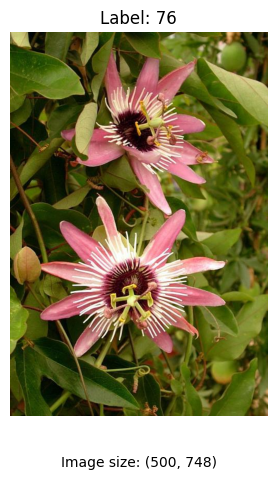

In [10]:
helper_utils.plot_img(img, label=label, info=img_size_info)

<br >

A continuación, inspecciona las etiquetas en el conjunto de datos. Para cada etiqueta única, imprime su descripción correspondiente utilizando el método `get_label_description`.

¿Cómo son las etiquetas?

In [11]:
# Get all labels from the dataset object.
dataset_labels = dataset.labels

# Create a set of unique labels to remove duplicates.
unique_labels = set(dataset_labels)

# Iterate through each unique label.
for label in unique_labels:
    # Print the numerical label and its corresponding text description.
    print(f'Label: {label}, Description: {dataset.get_label_description(label)}')

Label: 0, Description: pink primrose
Label: 1, Description: hard-leaved pocket orchid
Label: 2, Description: canterbury bells
Label: 3, Description: sweet pea
Label: 4, Description: english marigold
Label: 5, Description: tiger lily
Label: 6, Description: moon orchid
Label: 7, Description: bird of paradise
Label: 8, Description: monkshood
Label: 9, Description: globe thistle
Label: 10, Description: snapdragon
Label: 11, Description: colt's foot
Label: 12, Description: king protea
Label: 13, Description: spear thistle
Label: 14, Description: yellow iris
Label: 15, Description: globe-flower
Label: 16, Description: purple coneflower
Label: 17, Description: peruvian lily
Label: 18, Description: balloon flower
Label: 19, Description: giant white arum lily
Label: 20, Description: fire lily
Label: 21, Description: pincushion flower
Label: 22, Description: fritillary
Label: 23, Description: red ginger
Label: 24, Description: grape hyacinth
Label: 25, Description: corn poppy
Label: 26, Descript

### Resumen de las Imágenes en el Conjunto de Datos

Ahora que tienes una clase de dataset funcional, puedes explorar las imágenes en el conjunto de datos. Harás uso de la función `visual_exploration` para visualizar algunas imágenes y obtener una mejor comprensión de los datos.

In [13]:
def visual_exploration(dataset, num_rows=2, num_cols=4):
    """
    Muestra una cuadrícula de muestras seleccionadas aleatoriamente de un dataset para inspección visual.

    Args:
        dataset: El objeto dataset del cual extraer muestras. Debe permitir
                 el indexado y tener un método `get_label_description`.
        num_rows (int): El número de filas en la cuadrícula de visualización.
        num_cols (int): El número de columnas en la cuadrícula de visualización.
    """
    # Calcular el número total de imágenes a mostrar en la cuadrícula.
    total_samples = num_rows * num_cols

    # Seleccionar un conjunto aleatorio de índices únicos del dataset.
    indices = np.random.choice(len(dataset), total_samples, replace=False)

    # Crear una cuadrícula de subplots para contener las imágenes.
    fig, axes = helper_utils.get_grid(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 4))

    # Iterar sobre cada eje de subplot y el índice de muestra aleatoria correspondiente.
    for ax, idx in zip(axes.flatten(), indices):
        # Recuperar la imagen y su etiqueta numérica del dataset.
        image, label = dataset[idx]

        # Obtener la descripción de texto legible para humanos de la etiqueta.
        description = dataset.get_label_description(label)

        # Formatear una nueva cadena de etiqueta que incluya tanto el número como la descripción.
        label = f"{label} - {description}"

        # Crear una cadena de información con el índice de la muestra y las dimensiones de la imagen.
        info = f"Index: {idx} Size: {image.size}"

        # Graficar la imagen en el subplot actual con su etiqueta e información.
        helper_utils.plot_img(image, label=label, info=info, ax=ax)

    # Renderizar y mostrar toda la cuadrícula de imágenes.
    plt.show()

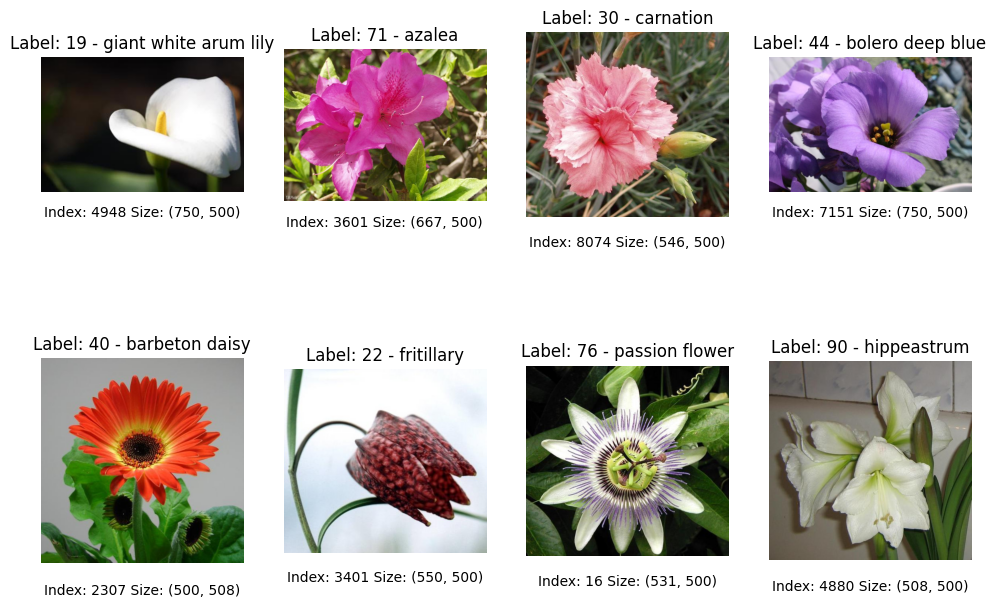

In [39]:
# Display a 2x4 grid of random samples from the dataset for visual inspection.
visual_exploration(dataset, num_rows=2, num_cols=4)

## Problemas de Calidad (Quality Problems)

Como has visto en la sección anterior, el tamaño de las imágenes en el conjunto de datos varía significativamente. Esto puede ser un problema al entrenar un modelo, ya que la mayoría de los modelos esperan que las imágenes de entrada tengan el mismo tamaño. Para abordar este problema, implementarás una serie de transformaciones para estandarizar el tamaño de las imágenes.

### Transformaciones (Transformations)

Después de explorar el conjunto de datos e identificar posibles problemas de calidad, el siguiente paso es aplicar transformaciones para preprocesar las imágenes.
Las transformaciones son operaciones que modifican las imágenes para prepararlas para el entrenamiento del modelo. Ejemplos comunes incluyen el redimensionamiento (resizing), el recorte (cropping), el volteo (flipping) y la normalización de los valores de los píxeles.
El módulo `torchvision.transforms` proporciona una variedad de transformaciones predefinidas que pueden aplicarse fácilmente a las imágenes.

Comenzarás definiendo un pipeline de transformación simple compuesto por dos etapas:

Transformaciones **aplicadas directamente a las imágenes en bruto**:
- `Resize((256, 256))`: Redimensiona cada imagen a un tamaño fijo de 256×256 píxeles.
- `CenterCrop(224)`: Recorta el centro de la imagen a 224×224 píxeles.

Transformaciones que **convierten y estandarizan las imágenes**:
- `ToTensor()`: Convierte una imagen PIL o un arreglo de NumPy en un tensor y escala los valores de los píxeles al rango [0, 1].
- `Normalize(mean, std)`: Normaliza el tensor utilizando la media y la desviación estándar especificadas.

**Nota**: 
El orden de las transformaciones a menudo importa. El redimensionamiento y el recorte deben aplicarse antes de convertir la imagen en un tensor.

In [17]:
# Define the mean values for normalization.
mean = [0.485, 0.456, 0.406]
# Define the standard deviation values for normalization.
std = [0.229, 0.224, 0.225]

In [18]:
transform = transforms.Compose([
    # images transforms
    transforms.Resize((256, 256)),  # Resize images to 256x256 pixels
    transforms.CenterCrop(224),  # Center crop to 224x224 pixels
    # bridge to tensor
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    # tensor transforms
    transforms.Normalize(mean=mean, std=std),
])

Ahora crearás una nueva instancia de la clase `FlowerDataset`, esta vez pasando el pipeline de transformación `transform` como argumento.

In [19]:
# Create a new dataset instance with the specified image transformations.
dataset_transformed = FlowerDataset(path_dataset, transform=transform)

Inspecciona la misma muestra nuevamente para ver el efecto de las transformaciones. Usando `quick_debug`, puedes observar que la imagen ha sido redimensionada y recortada a 224x224 píxeles, y los valores de sus píxeles han sido normalizados.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


Shape: torch.Size([3, 224, 224])
Type: torch.float32
Range of pixel values: [-2.1, 2.6]


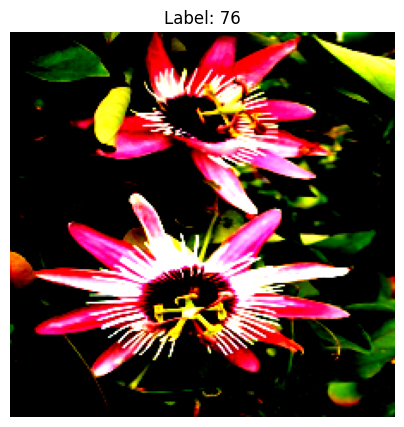

In [31]:
# Retrieve the transformed image and its label using the same index.
img_transformed, label = dataset_transformed[sel_idx]

# quick check
helper_utils.quick_debug(img_transformed)

# Plot the transformed image
helper_utils.plot_img(img_transformed, label=label)

<br>

Observa que la imagen ahora es un tensor con la forma `[3, 224, 224]`, lo que representa 3 canales de color (RGB) y 224×224 píxeles.
Debido a que los valores de los píxeles han sido normalizados, ya no se encuentran en el rango original de [0, 255].

Es por eso que la imagen se ve diferente cuando se visualiza directamente.
Para mostrarla correctamente, primero debes *desnormalizarla*. Puedes hacer esto aplicando la transformación `Normalize` nuevamente, utilizando los valores de `new_mean` y `new_std` para revertir el proceso de normalización.

In [40]:
class Denormalize:
    """
    Una clase invocable (callable) para revertir la normalización de una imagen en formato tensor.

    Esta clase calcula la transformación inversa de una normalización estándar
    y puede usarse como un paso de transformación, por ejemplo, para visualizar imágenes
    después de haber sido normalizadas para un modelo.
    """
    def __init__(self, mean, std):
        """
        Inicializa la transformación de desnormalización.

        Args:
            mean (list o tuple): Los valores de media utilizados para la normalización original.
            std (list o tuple): Los valores de desviación estándar utilizados para la
                                normalización original.
        """
        # Calcular la media ajustada para el proceso de desnormalización.
        new_mean = [-m / s for m, s in zip(mean, std)]
        # Calcular la desviación estándar ajustada para el proceso de desnormalización.
        new_std = [1 / s for s in std]
        # Crear un objeto de transformación Normalize con los parámetros inversos.
        self.denormalize = transforms.Normalize(mean=new_mean, std=new_std)

    def __call__(self, tensor):
        """
        Aplica la transformación de desnormalización a un tensor.

        Args:
            tensor: El tensor normalizado que se desea desnormalizar.

        Retorna:
            El tensor desnormalizado.
        """
        # Aplicar la transformación de desnormalización al tensor de entrada.
        return self.denormalize(tensor)

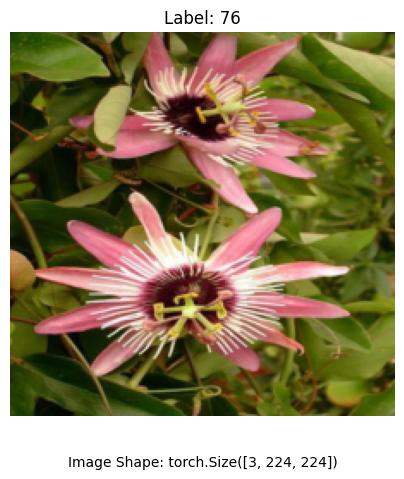

In [41]:
# Crear una instancia de la clase Denormalize con la media y desviación estándar originales.
denormalize = Denormalize(mean=mean, std=std)
# Aplicar la transformación de desnormalización al tensor de la imagen.
img_tensor = denormalize(img_transformed)

# Crear una cadena de información con la forma (shape) del tensor.
img_shape_info = f"Image Shape: {img_tensor.size()}"
# Graficar la imagen desnormalizada para visualizar el resultado.
helper_utils.plot_img(img_tensor, label=label, info=img_shape_info)

## Carga de Datos (Data Loading)

En esta sección, aprenderás cómo preparar y servir datos de manera eficiente para el entrenamiento de modelos en PyTorch.
Un proceso de entrenamiento completo incluye típicamente tres etapas: entrenamiento, validación y evaluación.

Durante el entrenamiento, el modelo aprende de los datos de entrenamiento ajustando sus pesos basándose en la función de pérdida. 
Durante la validación, el modelo se evalúa en un conjunto de datos separado para ajustar los hiperparámetros y prevenir el sobreajuste (overfitting).
Durante la evaluación, el rendimiento del modelo se prueba con datos no vistos para evaluar su capacidad de generalización.

Cada una de estas etapas requiere dividir el conjunto de datos en subconjuntos distintos y utilizar cargadores de datos (data loaders) para alimentar los datos de manera eficiente durante el entrenamiento y las pruebas. A continuación, verás cómo hacer esto utilizando PyTorch.

### División del Conjunto de Datos (Splitting the Dataset)

La función `split_dataset` dividirá el conjunto de datos en conjuntos de entrenamiento, validación y prueba.
Para lograr esto, deberás:

* Definir los tamaños de cada subconjunto a partir de las fracciones proporcionadas para validación y prueba,
* Utilizar `random_split` de `torch.utils.data` para realizar la división real.

In [42]:
def split_dataset(dataset, val_fraction=0.15, test_fraction=0.15):
    """
    Divide el conjunto de datos en conjuntos de entrenamiento, validación y prueba.
    
    Por defecto, esta función divide los datos en 70% para entrenamiento,
    15% para validación y 15% para pruebas.
    """

    # Calcular los tamaños de cada división.
    total_size = len(dataset)
    val_size = int(total_size * val_fraction)
    test_size = int(total_size * test_fraction)
    train_size = total_size - val_size - test_size

    # Usar random_split para crear los conjuntos de datos.
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    return train_dataset, val_dataset, test_dataset

In [43]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset_transformed)

Verifique los tamaños de los conjuntos de datos resultantes para asegurarse de que coincidan con las proporciones esperadas.

In [44]:
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   5733
Length of validation dataset: 1228
Length of test dataset:       1228


### Cargadores de Datos (Dataloaders)

Una vez que tu conjunto de datos está dividido en conjuntos de entrenamiento, validación y prueba, el siguiente paso es servir los datos de manera eficiente a tu modelo durante el entrenamiento y la evaluación. 
La clase `DataLoader` de PyTorch se encarga de esto agrupando las muestras en lotes (batches), mezclando (shuffling) los datos durante el entrenamiento y simplificando la iteración sobre tu dataset.
El uso de dataloaders ayuda a acelerar el entrenamiento y asegura que tu modelo vea una mezcla diversa de muestras en cada lote.

Ahora crearás dataloaders para cada subconjunto de los datos (entrenamiento, validación y prueba).
Utilizarás la clase `DataLoader` de `torch.utils.data` para crear los cargadores.
Los argumentos que proporcionarás incluyen:
- `dataset`: El conjunto de datos desde el cual cargar los datos (por ejemplo, `train_dataset`, `val_dataset`, `test_dataset`),
- `batch_size`: El número de muestras por lote a cargar (por ejemplo, `32`),
- `shuffle`: Si se deben mezclar los datos en cada época (típicamente `True` para entrenamiento y `False` para validación y prueba).

In [45]:
# Establecer el tamaño del lote (batch size) para los cargadores de datos.
batch_size = 32

# Crear el DataLoader para el conjunto de entrenamiento, con la mezcla (shuffling) habilitada.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Crear el DataLoader para el conjunto de validación, con la mezcla deshabilitada.
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Crear el DataLoader para el conjunto de prueba, con la mezcla deshabilitada.
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Para entender cómo funcionan los dataloaders, puedes iterar durante dos épocas sobre los dataloaders de entrenamiento y validación y, al final, iterar sobre el dataloader de prueba.
Esto te dará una idea de cómo se sirven los datos en lotes (batches) durante el entrenamiento y la evaluación.

In [46]:
# Define the total number of training epochs.
n_epochs = 2

In [47]:
# Iniciar el bucle principal de entrenamiento para cada época.
for epoch in range(n_epochs):
    # Imprimir un encabezado para indicar el inicio de una nueva época.
    print(f"=== Processing epoch {epoch} ===")

    # Anunciar el inicio de la fase de entrenamiento.
    print(f"Pass number {epoch} through the training set")
    print('Training...')
    # Obtener el número total de muestras en el conjunto de entrenamiento.
    train_samples = len(train_dataset)
    # Crear una barra de progreso para el cargador de datos de entrenamiento.
    train_bar = helper_utils.get_dataloader_bar(train_dataloader, color='blue')
    
    # Iterar sobre el cargador de datos de entrenamiento para obtener lotes de imágenes y etiquetas.
    for batch, (images, labels) in enumerate(train_dataloader):
        # Actualizar la barra de progreso de entrenamiento para el lote actual.
        helper_utils.update_dataloader_bar(train_bar, batch, batch_size, train_samples)

    # Anunciar el inicio de la fase de validación.
    print(f"\nPass number {epoch} through the validation set")
    print('Validation...')
    # Crear una barra de progreso para el cargador de datos de validación.
    val_bar = helper_utils.get_dataloader_bar(val_dataloader, color='orange')
    # Obtener el número total de muestras en el conjunto de validación.
    val_samples = len(val_dataset)
    
    # Iterar sobre el cargador de datos de validación para obtener lotes de imágenes y etiquetas.
    for batch, (images, labels) in enumerate(val_dataloader):
        # Actualizar la barra de progreso de validación para el lote actual.
        helper_utils.update_dataloader_bar(val_bar, batch, batch_size, val_samples)

=== Processing epoch 0 ===
Pass number 0 through the training set
Training...


                                                                                                              …


Pass number 0 through the validation set
Validation...


                                                                                                              …

=== Processing epoch 1 ===
Pass number 1 through the training set
Training...


                                                                                                              …


Pass number 1 through the validation set
Validation...


                                                                                                              …

In [48]:
# Anunciar la evaluación final en el conjunto de prueba.
print("\nPasada final a través del conjunto de prueba para evaluación")
# Crear una barra de progreso para el cargador de datos de prueba.
test_bar = helper_utils.get_dataloader_bar(test_dataloader, color='green')
# Obtener el número total de muestras en el conjunto de prueba.
test_samples = len(test_dataset)

# Iterar sobre el cargador de datos de prueba para obtener lotes de imágenes y etiquetas.
for batch, (images, labels) in enumerate(test_dataloader):
    # Actualizar la barra de progreso de prueba para el lote actual.
    helper_utils.update_dataloader_bar(test_bar, batch, batch_size, test_samples)


Pasada final a través del conjunto de prueba para evaluación


                                                                                                              …

<br>
Puedes observar que el cargador de datos de entrenamiento (training dataloader) tiene un total de 180 lotes (para un total de 5733 muestras). Los cargadores de validación y de prueba tienen 39 lotes cada uno (para un total de 1228 muestras cada uno).

## Aumento de Datos (Augmentation)

El aumento de datos es una técnica importante para mejorar la robustez y la generalización de los modelos de aprendizaje profundo.
Al aplicar transformaciones aleatorias, como volteos, rotaciones o ajustes de brillo a las imágenes de entrenamiento, el aumento ayuda a los modelos a reconocer objetos bajo diversas condiciones del mundo real.

En PyTorch, el aumento se puede realizar "sobre la marcha" (on-the-fly), generando variaciones infinitas de imágenes sin necesidad de almacenamiento extra.

Dentro de `get_augmentation_transform`, crearás un pipeline de transformación más avanzado que incluya técnicas de aumento de datos (data augmentation).
Este pipeline consta de lo siguiente:

Transformaciones que aumentan las imágenes en bruto:
- `RandomHorizontalFlip(p=0.5)`: Esta transformación voltea aleatoriamente la imagen de forma horizontal con una probabilidad de 0.5.
- `RandomRotation(degrees=10)`: Esta transformación rota aleatoriamente la imagen dentro de un rango de -10 a +10 grados.
- `ColorJitter(brightness=0.2)`: Esta transformación cambia aleatoriamente el brillo, contraste, saturación y matiz de la imagen.

Transformaciones que estandarizan las imágenes como `transform`: `Resize`, `CenterCrop`, `ToTensor` y `Normalize`.

Luego, crearás una nueva instancia de la clase `FlowerDataset`, esta vez pasando el pipeline de transformación con aumento `augmentation_transform` como argumento.

In [49]:
def get_augmentation_transform(mean, std):
    """
    Crea y devuelve una composición de transformaciones de imagen para el aumento de datos
    y el preprocesamiento.

    Args:
        mean (list o tuple): Una secuencia de valores de media para cada canal.
        std (list o tuple): Una secuencia de valores de desviación estándar para cada canal.

    Returns:
        torchvision.transforms.Compose: Un pipeline compuesto de transformaciones.
    """
    # Definir una lista de transformaciones de aumento de datos para ser aplicadas aleatoriamente.
    augmentations_transforms = [
        # Voltear aleatoriamente la imagen de forma horizontal con una probabilidad del 50%.
        transforms.RandomHorizontalFlip(p=0.5),
        # Rotar aleatoriamente la imagen dentro de un rango de +/- 10 grados.
        transforms.RandomRotation(degrees=10),
        # Ajustar aleatoriamente el brillo de la imagen.
        transforms.ColorJitter(brightness=0.2),
    ]
    
    # Definir la lista principal de transformaciones estándar no aleatorias.
    main_transforms = [
        # Redimensionar la imagen de entrada a 256x256 píxeles.
        transforms.Resize((256, 256)),
        # Recortar los 224x224 píxeles centrales de la imagen.
        transforms.CenterCrop(224),
        # Convertir la imagen PIL a un tensor de PyTorch.
        transforms.ToTensor(),
        # Normalizar el tensor con la media y la desviación estándar proporcionadas.
        transforms.Normalize(mean=mean, std=std),
    ]

    # Combinar las transformaciones de aumento y las principales en un solo pipeline.
    transform = transforms.Compose(augmentations_transforms + main_transforms)
    # Devolver el objeto de transformación compuesto final.
    return transform

In [50]:
# Create the augmentation and preprocessing pipeline, providing the normalization stats.
augmentation_transform = get_augmentation_transform(mean=mean, std=std)

# Initialize a new dataset instance that will use the augmentation pipeline.
dataset_augmented = FlowerDataset(path_dataset, transform=augmentation_transform)

Depurar un pipeline de dataset es un paso relevante para asegurar que las transformaciones y los procesos de carga de datos funcionen según lo previsto.
`visualize_augmentation` te permite visualizar el efecto de las transformaciones de aumento en una imagen de muestra.

Para un número determinado de versiones, recupera la misma imagen de muestra del dataset. Dado que el dataset aplica transformaciones aleatorias, cada versión recuperada de la imagen se verá afectada de manera diferente, lo que te permite ver la variedad de aumentos aplicados.

In [51]:
def visualize_augmentations(dataset_aug, idx=0, num_versions=8):
    """
    Muestra múltiples versiones aumentadas de una sola imagen de un dataset.

    Esta función recupera repetidamente una imagen de un dataset que tiene habilitadas
    las transformaciones de aumento, luego muestra cada versión única generada 
    aleatoriamente en una cuadrícula para ayudar a visualizar el efecto de las transformaciones.

    Args:
        dataset_aug: El objeto dataset con transformaciones de aumento aplicadas.
        idx (int): El índice de la imagen en el dataset que se desea visualizar.
        num_versions (int): El número total de versiones aumentadas a mostrar.
    """
    # Crear una transformación de desnormalización para revertir la normalización y poder mostrar la imagen.
    denormalize = Denormalize(mean, std)

    # Establecer el número de filas para la cuadrícula de visualización.
    n_rows = 2
    # Calcular el número de columnas necesarias basándose en el total de versiones a mostrar.
    n_cols = num_versions // n_rows
    # Crear una cuadrícula de subplots para mostrar las imágenes.
    fig, axes = helper_utils.get_grid(n_rows, n_cols, figsize=(16, 8))

    # Iterar a través de cada eje de subplot en la cuadrícula.
    for ax in axes.flatten():
        # Obtener una nueva versión aumentada aleatoriamente de la misma imagen por su índice.
        img, label = dataset_aug[idx]

        # Desnormalizar el tensor de la imagen para que pueda mostrarse correctamente.
        img = denormalize(img)

        # Graficar la imagen aumentada en el subplot actual.
        helper_utils.plot_img(img=img, ax=ax)

    # Mostrar la cuadrícula completa de imágenes aumentadas.
    plt.show()

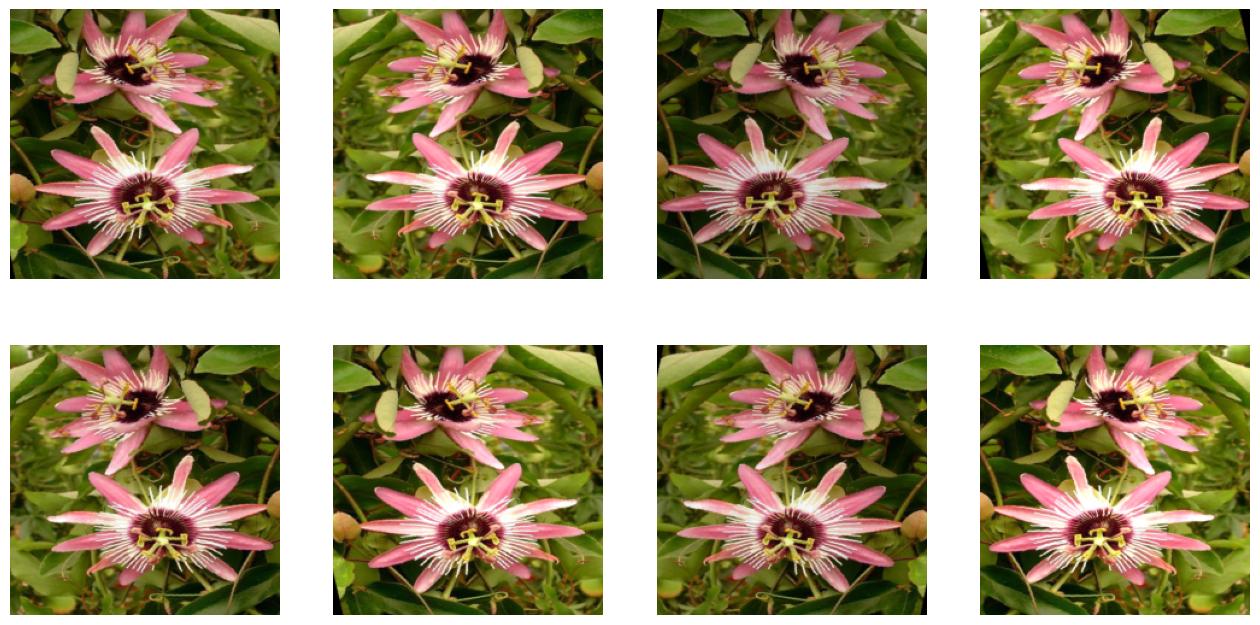

In [52]:
# Display 8 augmented versions of the selected image to see the transformations.
visualize_augmentations(dataset_augmented, idx=sel_idx, num_versions=8)

### División con Aumento de Datos (Splitting with Augmentation)

Integrar una división aleatoria adecuada con el aumento de datos requiere un manejo cuidadoso para asegurar que los conjuntos de entrenamiento, validación y prueba sean distintos y que el aumento se aplique únicamente a los datos de entrenamiento.

Un punto sutil a considerar es que, al usar `random_split`, cada una de las divisiones es un objeto `Subset` que hace referencia al dataset original.
Por lo tanto, esos subconjuntos heredarán las transformaciones definidas en el dataset original y no se les pueden asignar transformaciones diferentes de manera directa.

Para abordar esto, crearás una clase de dataset personalizada llamada `SubsetWithTransform`, la cual envuelve un objeto `Subset` y te permite especificar una transformación diferente para él.

In [53]:
class SubsetWithTransform(Dataset):
    """
    Un envoltorio para un Subset de PyTorch que aplica una transformación específica.

    Esta clase permite aplicar un conjunto diferente de transformaciones a un
    subconjunto de un dataset, lo cual es útil para crear conjuntos distintos de
    entrenamiento, validación o prueba con diferentes pasos de preprocesamiento
    a partir del mismo dataset base.
    """
    def __init__(self, subset, transform=None):
        """
        Inicializa el objeto SubsetWithTransform.

        Args:
            subset: Un objeto Subset de PyTorch que contiene una porción de un dataset.
            transform (callable, opcional): Una transformación opcional para ser aplicada
                a las muestras dentro de este subconjunto.
        """
        # Almacenar el subconjunto original del dataset.
        self.subset = subset
        # Almacenar las transformaciones que se aplicarán.
        self.transform = transform

    def __len__(self):
        """
        Devuelve el número total de muestras en el subconjunto.
        """
        # Devolver la longitud del subconjunto subyacente.
        return len(self.subset)

    def __getitem__(self, idx):
        """
        Recupera una muestra y aplica la transformación.

        Args:
            idx (int): El índice de la muestra a recuperar.

        Retorna:
            tuple: Una tupla que contiene la imagen transformada y su etiqueta.
        """
        # Obtener la imagen y etiqueta originales del subconjunto subyacente.
        image, label = self.subset[idx]
        # Verificar si se ha proporcionado una transformación.
        if self.transform:
            # Aplicar la transformación a la imagen.
            image = self.transform(image)
        # Retornar la imagen transformada y su etiqueta.
        return image, label

In [54]:
# Apply the augmentation pipeline to the training subset.
train_dataset = SubsetWithTransform(train_dataset, transform=augmentation_transform)
# Apply the basic preprocessing transform to the validation subset.
val_dataset = SubsetWithTransform(val_dataset, transform=transform)
# Apply the basic preprocessing transform to the test subset.
test_dataset = SubsetWithTransform(test_dataset, transform=transform)

Puedes comprobar que, en efecto, el conjunto de datos de entrenamiento tiene aplicadas las transformaciones de aumento (augmentation), mientras que los conjuntos de validación y prueba no las tienen.

In [55]:
print(train_dataset.transform)
print(val_dataset.transform)
print(test_dataset.transform)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.8, 1.2), contrast=None, saturation=None, hue=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


## Datasets Robustos (Robust Datasets)

En proyectos del mundo real, los pipelines de datos deben ser resilientes ante problemas inesperados, como archivos corruptos, formatos de imagen inconsistentes o muestras problemáticas que pueden interrumpir la ejecución del entrenamiento.
Esta sección presenta estrategias de diseño de datasets robustos.

### Manejo de Errores (Error Handling)

Crearás una nueva clase de dataset personalizada llamada `RobustFlowerDataset` que extiende la clase `FlowerDataset` original para manejar problemas potenciales con imágenes corruptas o problemáticas.

Los métodos `__init__`, `__len__` y `load_and_correct_labels` permanecen mayormente iguales a los de la clase `FlowerDataset` original.

Las principales diferencias son:

> `__getitem__`: Implementa un bloque try-except para capturar excepciones que puedan ocurrir al cargar una imagen.
> * Si ocurre una excepción (por ejemplo, debido a un archivo de imagen corrupto), el código imprimirá y registrará el error llamando al método `log_error`.
> * Luego, intenta recuperar la siguiente imagen en el dataset en lugar de detener la ejecución.

> `retrieve_image`: Maneja el proceso real de carga de la imagen.
> * Construye el nombre del archivo y la ruta, verifica la integridad de la imagen usando el método `verify()` de Pillow y vuelve a cargar la imagen para asegurar que esté completamente cargada en la memoria.
> * Verifica el tamaño de la imagen, lanzando un error si es menor a 32 píxeles en cualquier dimensión, y convierte las imágenes en escala de grises a RGB para mantener la consistencia.

> `get_error_summary`: Proporciona un resumen de todos los errores encontrados durante la carga de datos, lo cual es útil para la depuración y para evaluar la calidad del dataset.

In [56]:
class RobustFlowerDataset(Dataset):
    """
    Una clase de dataset personalizada con manejo de errores robusto para la carga de imágenes.

    Esta clase está diseñada para manejar con elegancia problemas con muestras de datos
    individuales, como archivos corruptos o formatos incorrectos. Registra cualquier error
    e intenta cargar una muestra diferente en lugar de detener la ejecución.
    """
    def __init__(self, root_dir, transform=None):
        """
        Inicializa el objeto del dataset.

        Args:
            root_dir (str): El directorio raíz donde se almacena el conjunto de datos.
            transform (callable, opcional): Transformación opcional que se aplicará sobre una muestra.
        """
        # Almacena la ruta del directorio raíz.
        self.root_dir = root_dir
        # Construye la ruta completa al directorio de imágenes.
        self.img_dir = os.path.join(root_dir, "jpg")
        # Almacena las transformaciones opcionales.
        self.transform = transform
        # Carga y procesa las etiquetas desde el archivo correspondiente.
        self.labels = self.load_and_correct_labels()
        # Inicializa una lista para hacer seguimiento de cualquier error encontrado.
        self.error_logs = []

    def __getitem__(self, idx):
        """
        Recupera una muestra, manejando errores al intentar con el siguiente elemento disponible.

        Args:
            idx (int): El índice de la muestra a recuperar.

        Retorna:
            tuple: Una tupla que contiene la imagen y su etiqueta.
        """
        # Bucle para intentar cargar una muestra válida, evitando un bucle infinito.
        for attempt in range(len(self)):
            # Intentar cargar y procesar la muestra.
            try:
                # Recuperar la imagen usando el método auxiliar.
                image = self.retrieve_image(idx)
                # Verificar si se ha proporcionado una transformación.
                if self.transform:
                    # Aplicar la transformación a la imagen.
                    image = self.transform(image)
                # Obtener la etiqueta para el índice actual.
                label = self.labels[idx]
                # Retornar la imagen válida y su etiqueta correspondiente.
                return image, label
            # Capturar cualquier excepción que ocurra durante el proceso.
            except Exception as e:
                # Registrar el error con su índice y mensaje.
                self.log_error(idx, e)
                # Moverse al siguiente índice, reiniciando desde cero si es necesario.
                idx = (idx + 1) % len(self)

    def __len__(self):
        """
        Devuelve el número total de muestras en el conjunto de datos.
        """
        # El número total de muestras es el número de etiquetas.
        return len(self.labels)

    def retrieve_image(self, idx):
        """
        Carga y valida una sola imagen desde el disco.

        Args:
            idx (int): El índice de la imagen a cargar.

        Retorna:
            PIL.Image.Image: El objeto de imagen cargado y validado.
        """
        # Construye el nombre del archivo de imagen basado en el índice.
        img_name = f"image_{idx+1:05d}.jpg"
        # Construye la ruta completa al archivo de imagen.
        img_path = os.path.join(self.img_dir, img_name)
        # Abre el archivo de imagen para verificar su integridad sin cargarla completamente.
        with Image.open(img_path) as img:
            # Realiza una verificación rápida de la estructura del archivo.
            img.verify()
        # Vuelve a abrir el archivo de imagen después de una verificación exitosa.
        image = Image.open(img_path)
        # Carga completamente los datos de la imagen en memoria.
        image.load()
        # Verifica si las dimensiones de la imagen están por debajo de un umbral mínimo.
        if image.size[0] < 32 or image.size[1] < 32:
            # Lanza un error para imágenes que son demasiado pequeñas.
            raise ValueError(f"Imagen demasiado pequeña: {image.size}")
        # Verifica si la imagen no está en modo de color RGB.
        if image.mode != "RGB":
            # Convierte la imagen a RGB.
            image = image.convert("RGB")
        # Retorna la imagen completamente cargada y validada.
        return image

    def load_and_correct_labels(self):
        """
        Carga las etiquetas desde un archivo .mat y las ajusta.

        Retorna:
            numpy.ndarray: Un arreglo de etiquetas enteras indexadas desde cero.
        """
        # Carga el archivo MATLAB que contiene las etiquetas.
        self.labels_mat = scipy.io.loadmat(
            os.path.join(self.root_dir, "imagelabels.mat")
        )
        # Extrae el arreglo de etiquetas y corrige para el indexado basado en cero.
        labels = self.labels_mat["labels"][0] - 1
        # Trunca el dataset a las primeras 10 etiquetas para una prueba rápida.
        labels = labels[:10]
        # Retorna las etiquetas procesadas.
        return labels

    def log_error(self, idx, e):
        """
        Registra los detalles de un error encontrado durante la carga de datos.

        Args:
            idx (int): El índice de la muestra problemática.
            e (Exception): El objeto de excepción que fue lanzado.
        """
        # Construye el nombre del archivo de la imagen problemática.
        img_name = f"image_{idx + 1:05d}.jpg"
        # Construye la ruta completa al archivo de imagen.
        img_path = os.path.join(self.img_dir, img_name)
        # Añade un diccionario con los detalles del error al registro.
        self.error_logs.append(
            {
                "index": idx,
                "error": str(e),
                "path": img_path if "img_path" in locals() else "unknown",
            }
        )
        # Imprime una advertencia en la consola sobre la imagen omitida.
        print(f"Advertencia: Omitiendo imagen corrupta {idx}: {e}")

    def get_error_summary(self):
        """
        Imprime un resumen de todos los errores encontrados durante el procesamiento del dataset.
        """
        # Verifica si el registro de errores está vacío.
        if not self.error_logs:
            # Imprime un mensaje indicando que el dataset está limpio.
            print("No se encontraron errores - ¡el dataset está limpio!")
        else:
            # Imprime el número total de imágenes problemáticas encontradas.
            print(f"\nSe encontraron {len(self.error_logs)} imágenes problemáticas:")
            # Itera a través de los primeros errores registrados.
            for error in self.error_logs[:5]:
                # Imprime los detalles de un error individual.
                print(f"  Índice {error['index']}: {error['error']}")
            # Verifica si hay más errores de los que se mostraron.
            if len(self.error_logs) > 5:
                # Imprime un resumen de los errores restantes.
                print(f"  ... y {len(self.error_logs) - 5} más")

El dataset Oxford Flowers 102 está limpio, pero para ilustrar las técnicas de robustez, un subconjunto de imágenes en el dataset ha sido corrompido intencionalmente. Los archivos de este subconjunto se encuentran en la carpeta `./corrupted_flower_data`.

Puedes crear una instancia de la clase `RobustFlowerDataset` pasando la ruta al dataset corrompido.

In [57]:
# Definir la ruta al directorio que contiene el conjunto de datos corrompido.
corrupted_dataset_path = './corrupted_flower_data'

# Inicializar el manejador de dataset robusto con la ruta a los datos corrompidos.
robust_dataset = RobustFlowerDataset(corrupted_dataset_path)

Advertencia: Omitiendo imagen corrupta 2: Imagen demasiado pequeña: (20, 20)


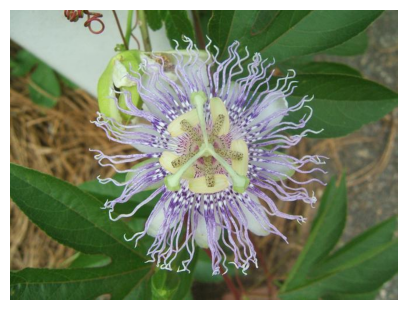

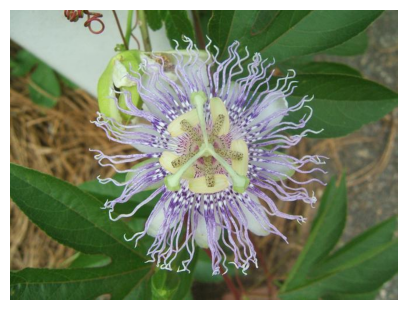

In [58]:
# Establecer el índice en una imagen que se sabe está corrompida. La imagen 2 es muy pequeña.
idx = 2

# Intentar recuperar la imagen; el dataset robusto omitirá la errónea y devolverá la siguiente.
img, label = robust_dataset[idx]

# Graficar la imagen recuperada, que debería ser la que sigue a la corrompida.
helper_utils.plot_img(img)

# Recuperar explícitamente la siguiente imagen en la secuencia para verificar.
next_img, next_label = robust_dataset[idx + 1]

# Graficar la siguiente imagen; debería ser idéntica a la anterior.
helper_utils.plot_img(next_img)

In [59]:
# Establecer el índice en una imagen que se sabe es de escala de grises.
# La imagen 4 está corrompida (escala de grises)
idx = 4

# Reconstruir la ruta al archivo de imagen original.
original_img_path = os.path.join(robust_dataset.img_dir, f"image_{idx + 1:05d}.jpg")
# Abrir la imagen original directamente para verificar su modo antes de la corrección.
original_img = Image.open(original_img_path)
# Imprimir el modo del archivo de imagen original sin corregir.
print(f"Modo del archivo de imagen original: {original_img.mode}")  # Imprime 'L' para escala de grises de 8 bits. Una imagen a color estándar sería 'RGB'.

Modo del archivo de imagen original: L


Modo de la imagen corregida: RGB


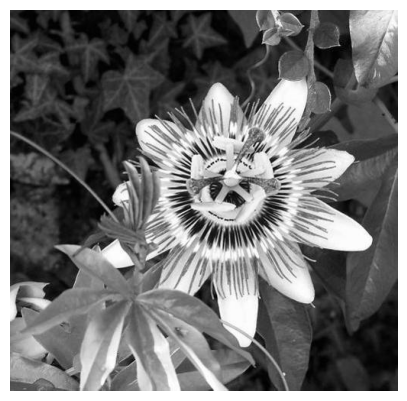

In [60]:
# Recuperar la imagen; el cargador robusto debería convertirla automáticamente a RGB.
img, label = robust_dataset[idx]

# Graficar la imagen para confirmar visualmente que ahora está en formato de color.
helper_utils.plot_img(img)

# Imprimir el modo de la imagen para confirmar que ha sido corregida a 'RGB'.
print(f"Modo de la imagen corregida: {img.mode}")

Advertencia: Omitiendo imagen corrupta 6: cannot identify image file './corrupted_flower_data/jpg/image_00007.jpg'


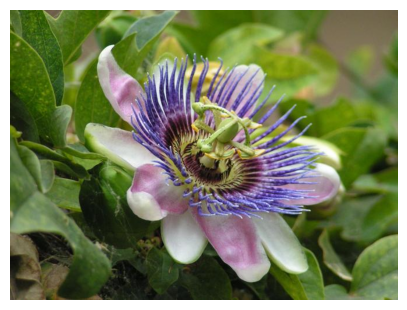

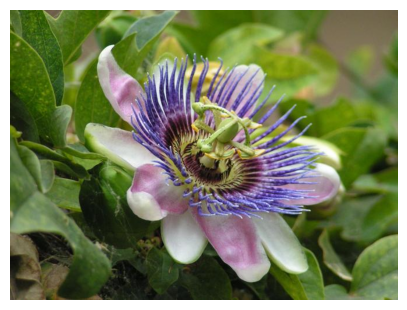

In [61]:
# Establecer el índice en una imagen que se sabe está corrompida o no se puede leer.
idx = 6

# Intentar recuperar la imagen; el cargador robusto debería omitir el archivo corrompido y devolver el siguiente.
robust_img = robust_dataset[idx][0]

# Graficar la imagen recuperada, que debería ser la muestra del siguiente índice (7).
helper_utils.plot_img(robust_img)

# Recuperar explícitamente la siguiente imagen en la secuencia para verificar la lógica de respaldo.
# Verificar la siguiente imagen para asegurar que sea correcta.
next_img, next_label = robust_dataset[idx + 1]

# Graficar la siguiente imagen; debería ser idéntica a la anterior, confirmando la omisión.
helper_utils.plot_img(next_img)

Puedes ver que las imágenes 2, 4 y 6 están corrompidas de diferentes maneras, pero la clase de dataset robusto es capaz de manejar esos casos en consecuencia.
Puedes obtener un resumen de los errores encontrados durante la carga de datos inspeccionando el atributo `error_logs`.

In [62]:
# Display the summary of any corrupted or problematic images found during loading.
robust_dataset.get_error_summary()


Se encontraron 2 imágenes problemáticas:
  Índice 2: Imagen demasiado pequeña: (20, 20)
  Índice 6: cannot identify image file './corrupted_flower_data/jpg/image_00007.jpg'


### Seguimiento de Errores (Tracking Errors)

En proyectos de aprendizaje profundo del mundo real, los pipelines de datos deben ser robustos no solo ante archivos corruptos, sino también ante problemas sutiles que pueden degradar silenciosamente el rendimiento del modelo. Mas alla de manejar excepciones, es importante realizar un seguimiento y analisis sistematico de los errores y anomalias que ocurren durante la carga de datos y el preprocesamiento.

Esta seccion final introduce estrategias practicas para el seguimiento de errores dentro de tu pipeline de dataset. Aprenderas a registrar muestras problematicas, monitorear que imagenes son accedidas (y con que frecuencia) y revisar resumenes de errores despues del entrenamiento. Estas tecnicas ayudan a asegurar que tu pipeline sea resiliente, transparente y este listo para produccion, permitiendote detectar y resolver problemas de calidad de datos antes de que afecten los resultados de tu modelo.

La clase `MonitoredDataset` extiende `RobustFlowerDataset` para agregar funciones de monitoreo sobre el acceso al conjunto de datos y el rendimiento de la carga.

- **Seguimiento de Acceso**: Cada vez que se carga una imagen a través de `__getitem__`, la clase incrementa un contador para ese índice de imagen en `self.access_counts`. Esto te permite rastrear con qué frecuencia se accede a cada muestra durante el entrenamiento o la evaluación.

- **Medición del Tiempo de Carga**: Esta clase registra el tiempo que tarda en cargarse cada imagen y almacena estos valores en `self.load_times`. Si la carga de una imagen tarda más de 1 segundo, se imprime una advertencia con el índice de la imagen y el tiempo de carga. Esto ayuda a identificar muestras de carga lenta que pueden afectar el rendimiento del entrenamiento.

- **Informe de Estadísticas**: El método `print_stats()` proporciona un resumen del uso del conjunto de datos, que incluye:
    - Número total de imágenes en el conjunto de datos
    - Número de imágenes únicas accedidas
    - Número de errores encontrados (heredado de la clase padre)
    - Tiempos promedio y máximo de carga de imágenes
    - Una advertencia si alguna imagen nunca fue accedida, con ejemplos

Estas capacidades de monitoreo te ayudan a detectar cuellos de botella, diagnosticar errores y garantizar la confiabilidad de tu pipeline de datos, lo que facilita la depuración y optimización del manejo de conjuntos de datos en flujos de trabajo de aprendizaje profundo.

La clase MonitoredDataset extiende RobustFlowerDataset para agregar funciones de monitoreo sobre el acceso al conjunto de datos y el rendimiento de la carga.

In [64]:
class MonitoredDataset(RobustFlowerDataset):
    """
    Extiende una clase de dataset robusta para añadir monitoreo de rendimiento.

    Esta clase rastrea métricas como la frecuencia con la que se accede a cada imagen,
    cuánto tiempo toma cada acceso y qué imágenes nunca se cargan. Proporciona
    un resumen de estas estadísticas para ayudar a diagnosticar problemas en el pipeline de datos.
    """
    def __init__(self, *args, **kwargs):
        """
        Inicializa el objeto del dataset monitoreado.

        Args:
            *args: Lista de argumentos de longitud variable pasados a la clase padre.
            **kwargs: Argumentos de palabras clave arbitrarios pasados a la clase padre.
        """
        # Inicializar la clase padre con todos los argumentos proporcionados.
        super().__init__(*args, **kwargs)
        # Inicializar un diccionario para contar cuántas veces se accede a cada índice.
        self.access_counts = {}
        # Inicializar una lista para almacenar el tiempo de carga de cada acceso.
        self.load_times = []

    def __getitem__(self, idx):
        """
        Recupera una muestra mientras monitorea los conteos de acceso y los tiempos de carga.

        Args:
            idx (int): El índice de la muestra a recuperar.

        Retorna:
            tuple: La muestra de datos (ej. imagen y etiqueta) de la clase padre.
        """
        # Importar el módulo time para operaciones de cronometraje.
        import time
        # Registrar el tiempo de inicio de la operación.
        start_time = time.time()
        # Incrementar el conteo de acceso para el índice dado.
        self.access_counts[idx] = self.access_counts.get(idx, 0) + 1
        # Llamar al método de la clase padre para cargar los datos.
        result = super().__getitem__(idx)
        # Calcular el tiempo total tomado para cargar la muestra.
        load_time = time.time() - start_time
        # Añadir el tiempo de carga calculado a la lista.
        self.load_times.append(load_time)
        # Verificar si el tiempo de carga excede un cierto umbral.
        if load_time > 1.0:
            # Imprimir una advertencia si se detecta un tiempo de carga lento.
            print(f"⚠️ Slow load: Image {idx} took {load_time:.2f}s")
        # Retornar la muestra cargada de la clase padre.
        return result

    def print_stats(self):
        """
        Imprime un resumen de las estadísticas de acceso y rendimiento del dataset.
        """
        # Imprimir un encabezado para el informe de estadísticas.
        print("\n=== Pipeline Statistics ===")
        # Mostrar el número total de imágenes en el dataset.
        print(f"Total images: {len(self)}")
        # Mostrar el número de imágenes únicas a las que se accedió.
        print(f"Unique images accessed: {len(self.access_counts)}")
        # Mostrar el número total de errores registrados por la clase padre.
        print(f"Errors encountered: {len(self.error_logs)}")
        # Verificar si se han registrado tiempos de carga.
        if self.load_times:
            # Calcular el tiempo de carga promedio.
            avg_time = sum(self.load_times) / len(self.load_times)
            # Encontrar el tiempo de carga máximo (el más lento).
            max_time = max(self.load_times)
            # Imprimir el tiempo de carga promedio en milisegundos.
            print(f"Average load time: {avg_time*1000:.1f} ms")
            # Imprimir el tiempo de carga más lento en milisegundos.
            print(f"Slowest load: {max_time*1000:.1f} ms")
        # Crear un conjunto de todos los índices posibles en el dataset.
        all_indices = set(range(len(self)))
        # Crear un conjunto de todos los índices a los que realmente se accedió.
        accessed_indices = set(self.access_counts.keys())
        # Encontrar el conjunto de índices a los que nunca se accedió.
        never_accessed = all_indices - accessed_indices
        # Verificar si hay imágenes que nunca fueron cargadas.
        if never_accessed:
            # Imprimir un mensaje de advertencia con el conteo de imágenes nunca accedidas.
            print(f"\n⚠️ WARNING: {len(never_accessed)} images were never loaded!")
            # Mostrar algunos ejemplos de los índices que nunca fueron accedidos.
            print(f"    Examples: {list(never_accessed)[:5]}")

In [65]:
# Inicializar el dataset monitoreado con la ruta a los datos potencialmente corrompidos.
monitored_dataset = MonitoredDataset(corrupted_dataset_path)

# Bucle a través de cada índice en el dataset para simular una pasada completa.
# Iterar a través del dataset para activar el monitoreo.
for idx in range(len(monitored_dataset)):
    # Acceder a la muestra en el índice actual para activar la lógica de monitoreo y manejo de errores.
    img, label = monitored_dataset[idx]

Advertencia: Omitiendo imagen corrupta 2: Imagen demasiado pequeña: (20, 20)
Advertencia: Omitiendo imagen corrupta 6: cannot identify image file './corrupted_flower_data/jpg/image_00007.jpg'


In [66]:
# Print the statistics
monitored_dataset.print_stats()


=== Pipeline Statistics ===
Total images: 10
Unique images accessed: 10
Errors encountered: 2
Average load time: 1.3 ms
Slowest load: 1.8 ms


El método `print_stats` proporciona una visión general completa del uso del conjunto de datos y de cualquier problema encontrado durante la carga de datos.
Esta es una buena práctica para implementar en tus clases de dataset, ya que te ayuda a monitorear la calidad de tus datos y el rendimiento de tu pipeline de datos.

## Conclusión

¡Felicitaciones! Ahora has construido un pipeline de datos completo y listo para producción en PyTorch.
En este laboratorio, fuiste más allá de trabajar con datos perfectamente curados y aprendiste a gestionar las complejidades del manejo de datos en el mundo real, desde el acceso inicial hasta el procesamiento eficiente por lotes (batching).

Viste cómo organizar un conjunto de datos desordenado creando una clase **`Dataset`** personalizada para cargar imágenes y etiquetas desde archivos separados. Aplicaste pasos de preprocesamiento esenciales, incluyendo **transformaciones** para normalizar tus datos y **aumento de datos (data augmentation)** para hacer que tu futuro modelo sea más robusto.

Luego utilizaste **`DataLoader`** para preparar tus datos mediante el agrupamiento en lotes y el barajado para el entrenamiento. Finalmente, hiciste que tu pipeline fuera más confiable implementando el manejo de errores y el monitoreo del rendimiento, asegurando que el proceso de entrenamiento de tu modelo sea estable y eficiente.

Has construido una base sólida en la gestión de datos que servirá de apoyo para todo lo que hagas a continuación.